In [1]:
import collections
from collections import OrderedDict
import pandas as pd
import time as tm

In [2]:
run -i "windows_door_algorithm.py"

# Example 1: Run thousands of data points

First showcase running thousands of data points, which represent some counter values from a software system.

In [3]:
data_size = 500
compressor = WindowsDoorCompression(data_size)

In [4]:
df = pd.read_csv('data/sample1.csv', parse_dates=True, index_col=0)
df['Counter'] = df['Counter'].astype(float)
data = {}
data = OrderedDict(sorted(data.items(), key=lambda t: t[0]))

for index, row in df.iterrows():
    data[index] = row['Counter']

In [5]:
t0 = tm.time()

exception = compressor._run_exception(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(exception)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(exception), "data points remaining"))

Initial deviation: 131.37307661595008
1549789882.7234461  seconds time elapsed in running exception.
1549789882.781091  seconds time elapsed in running exception.
0.05764484405517578  seconds time elapsed in running exception.
5960 number of data points discarded as part of exception window
510 data points remaining


In [6]:
exception_modified = {}

for time, value in exception.items():
    exception_modified[time] = [time, value]

exception_df = pd.DataFrame.from_dict(exception_modified, orient='index')
exception_df.columns = ['Date', 'Counter']
exception_df.set_index('Date', inplace=True)

In [7]:
t0 = tm.time()

compression = compressor._run_compression(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(compression)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(compression), "data points remaining"))

Initial deviation: 131.37307661595008
1549789885.679712  seconds time elapsed in running exception.
1549789885.7869408  seconds time elapsed in running exception.
0.10722875595092773  seconds time elapsed in running exception.
5970 number of data points discarded as part of exception window
500 data points remaining


In [8]:
compression_modified = {}

for time, value in compression.items():
    compression_modified[time] = [time, value]
    
compression_df = pd.DataFrame.from_dict(compression_modified, orient='index')
compression_df.columns = ['Date', 'Counter']
compression_df.set_index('Date', inplace=True)

In [9]:
t0 = tm.time()

hybrid = compressor._run_hybrid(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(hybrid)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(hybrid), "data points remaining"))

Initial deviation: 131.37307661595008
1549789889.569669  seconds time elapsed in running exception.
1549789889.675906  seconds time elapsed in running exception.
0.10623693466186523  seconds time elapsed in running exception.
5970 number of data points discarded as part of exception window
500 data points remaining


In [10]:
hybrid_modified = {}

for time, value in hybrid.items():
    hybrid_modified[time] = [time, value]
    
hybrid_df = pd.DataFrame.from_dict(hybrid_modified, orient='index')
hybrid_df.columns = ['Date', 'Counter']
hybrid_df.set_index('Date', inplace=True)

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'sqrt', 'time', 'inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


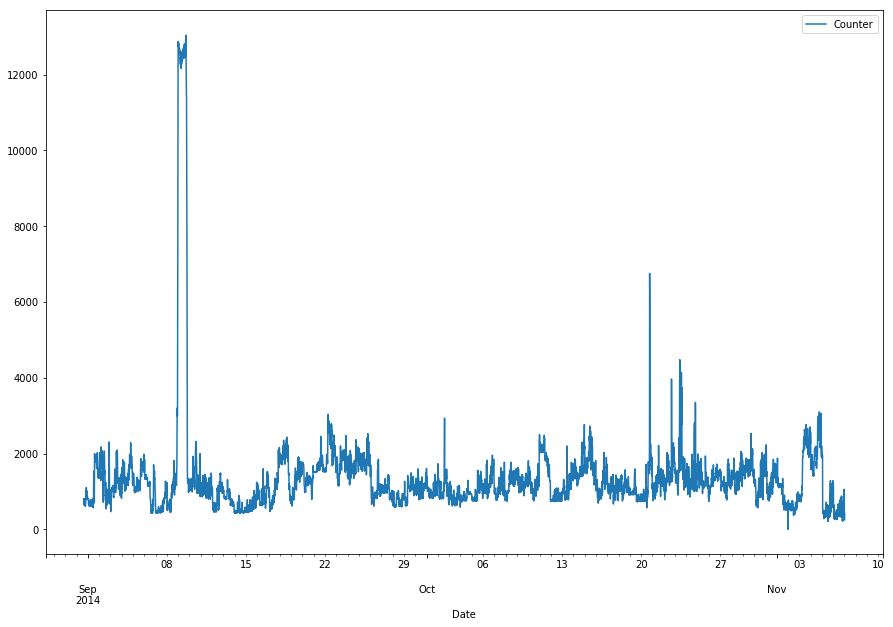

In [11]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
df.plot()

Populating the interactive namespace from numpy and matplotlib


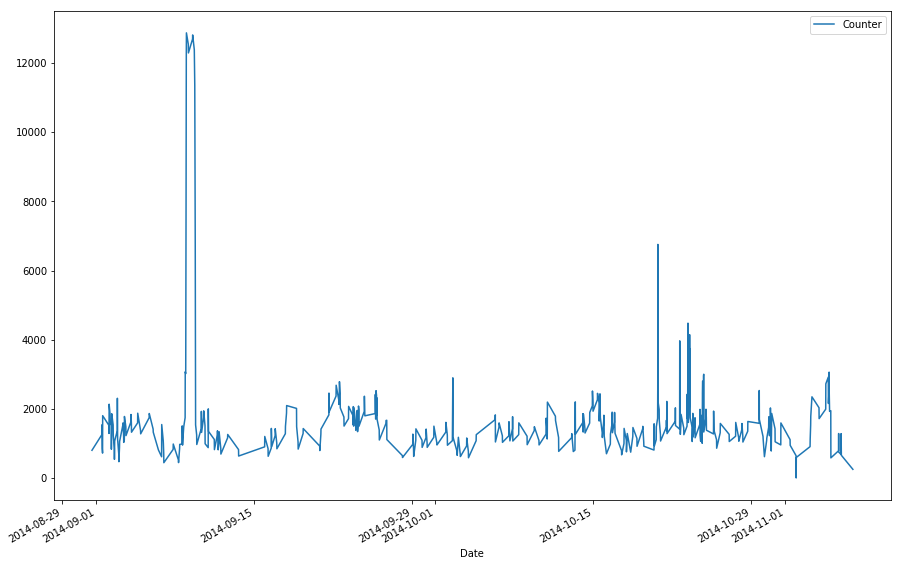

In [12]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
exception_df.plot()

Populating the interactive namespace from numpy and matplotlib


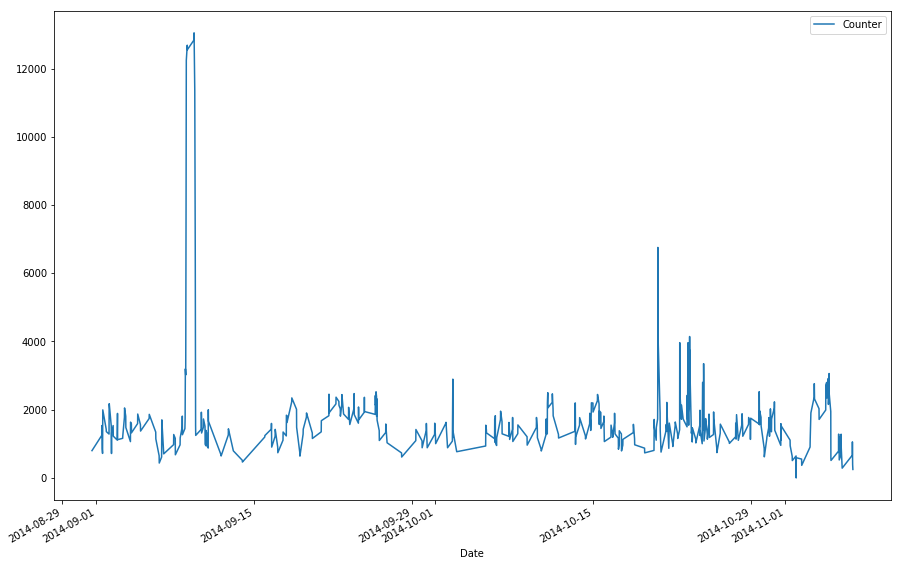

In [13]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
compression_df.plot()

Populating the interactive namespace from numpy and matplotlib


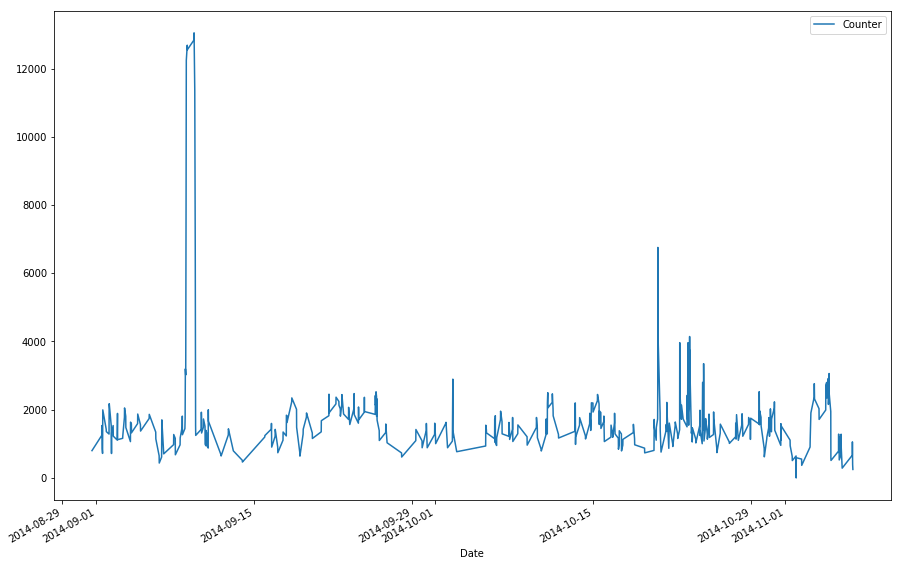

In [14]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
hybrid_df.plot()

# Example 2: Run tens of data points

Second showcase tens of float data points.

In [15]:
data_size = 30
compressor = WindowsDoorCompression(data_size)

In [16]:
df = pd.read_csv('data/sample2.csv', parse_dates=True, index_col=0)
df['Value'] = df['Value'].astype(float)
data = {}
data = OrderedDict(sorted(data.items(), key=lambda t: t[0]))

for index, row in df.iterrows():
    data[index] = row['Value']

In [17]:
t0 = tm.time()

exception = compressor._run_exception(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(exception)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(exception), "data points remaining"))

Initial deviation: 1.2070796028048498
1549789913.221408  seconds time elapsed in running exception.
1549789913.2225568  seconds time elapsed in running exception.
0.0011489391326904297  seconds time elapsed in running exception.
38 number of data points discarded as part of exception window
33 data points remaining


In [18]:
exception_modified = {}

for time, value in exception.items():
    exception_modified[time] = [time, value]

exception_df = pd.DataFrame.from_dict(exception_modified, orient='index')
exception_df.columns = ['Date', 'Counter']
exception_df.set_index('Date', inplace=True)

In [19]:
t0 = tm.time()

compression = compressor._run_compression(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(compression)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(compression), "data points remaining"))

Initial deviation: 1.2070796028048498
1549789914.3465269  seconds time elapsed in running exception.
1549789914.348701  seconds time elapsed in running exception.
0.0021741390228271484  seconds time elapsed in running exception.
42 number of data points discarded as part of exception window
29 data points remaining


In [20]:
compression_modified = {}

for time, value in compression.items():
    compression_modified[time] = [time, value]
    
compression_df = pd.DataFrame.from_dict(compression_modified, orient='index')
compression_df.columns = ['Date', 'Counter']
compression_df.set_index('Date', inplace=True)

In [21]:
t0 = tm.time()

hybrid = compressor._run_hybrid(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(hybrid)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(hybrid), "data points remaining"))

Initial deviation: 1.2070796028048498
1549789915.570601  seconds time elapsed in running exception.
1549789915.57283  seconds time elapsed in running exception.
0.002228975296020508  seconds time elapsed in running exception.
42 number of data points discarded as part of exception window
29 data points remaining


In [22]:
hybrid_modified = {}

for time, value in hybrid.items():
    hybrid_modified[time] = [time, value]
    
hybrid_df = pd.DataFrame.from_dict(hybrid_modified, orient='index')
hybrid_df.columns = ['Date', 'Counter']
hybrid_df.set_index('Date', inplace=True)

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


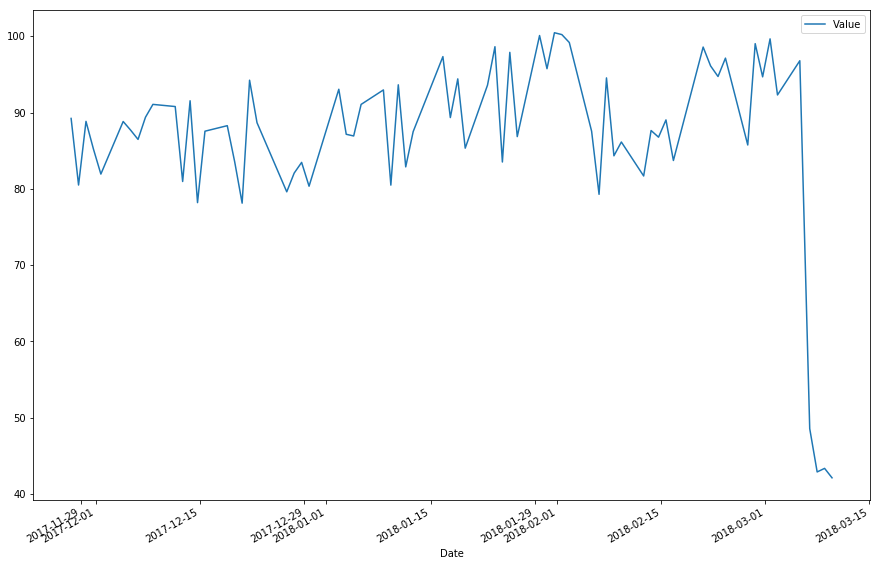

In [23]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
df.plot()

Populating the interactive namespace from numpy and matplotlib


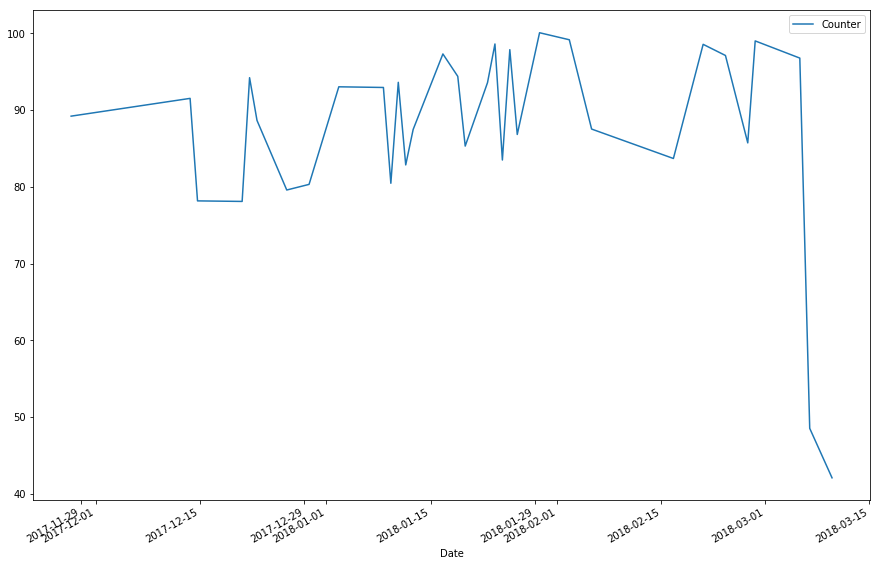

In [24]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
exception_df.plot()

Populating the interactive namespace from numpy and matplotlib


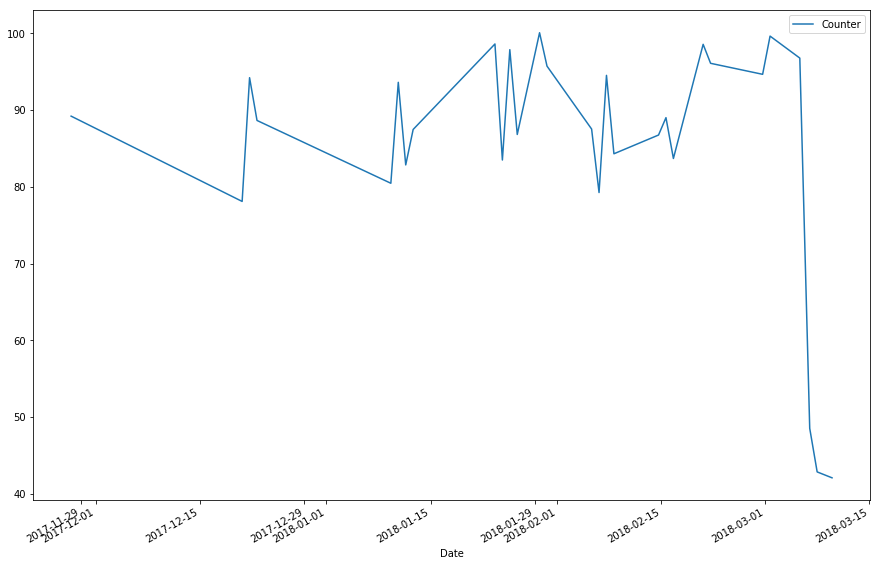

In [25]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
compression_df.plot()

Populating the interactive namespace from numpy and matplotlib


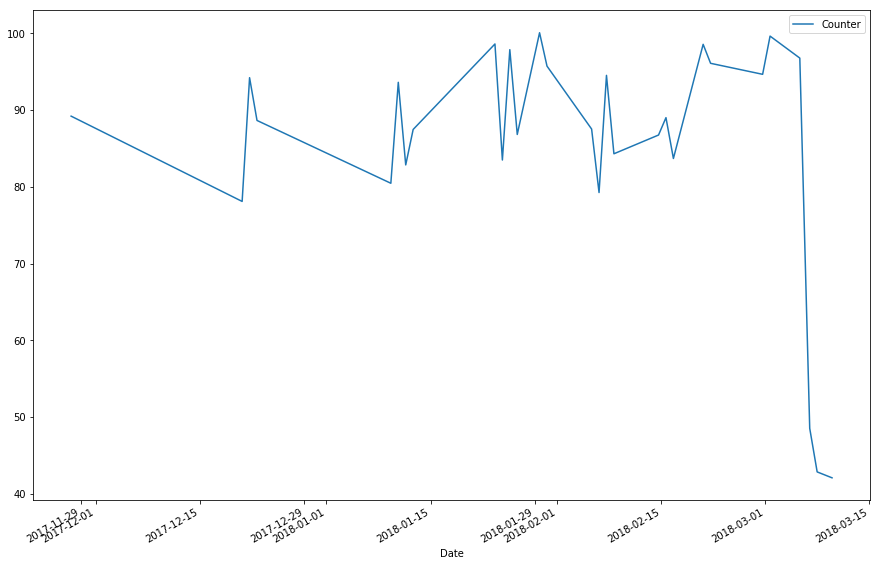

In [26]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
hybrid_df.plot()

# Example 3: Run millions of data points

Third showcase large dataset, random generated from excel with some range.

In [27]:
data_size = 500
compressor = WindowsDoorCompression(data_size)

In [28]:
df = pd.read_csv('data/sample3.csv', parse_dates=True, index_col=0)
df['Counter'] = df['Counter'].astype(float)
data = {}
data = OrderedDict(sorted(data.items(), key=lambda t: t[0]))

for index, row in df.iterrows():
    data[index] = row['Counter']

In [29]:
t0 = tm.time()

exception = compressor._run_exception(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(exception)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(exception), "data points remaining"))

Initial deviation: 3724.571707649736
2  iteration:  468167  data points remaining. 
3  iteration:  69693  data points remaining. 
1549790121.75313  seconds time elapsed in running exception.
1549790131.514818  seconds time elapsed in running exception.
9.761687994003296  seconds time elapsed in running exception.
958110 number of data points discarded as part of exception window
8 data points remaining


In [30]:
exception_modified = {}

for time, value in exception.items():
    exception_modified[time] = [time, value]

exception_df = pd.DataFrame.from_dict(exception_modified, orient='index')
exception_df.columns = ['Date', 'Counter']
exception_df.set_index('Date', inplace=True)

In [ ]:
t0 = tm.time()

compression = compressor._run_compression(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(compression)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(compression), "data points remaining"))

Initial deviation: 3724.571707649736
2  iteration:  638202  data points remaining. 
3  iteration:  348054  data points remaining. 


In [ ]:
compression_modified = {}

for time, value in compression.items():
    compression_modified[time] = [time, value]
    
compression_df = pd.DataFrame.from_dict(compression_modified, orient='index')
compression_df.columns = ['Date', 'Counter']
compression_df.set_index('Date', inplace=True)

In [ ]:
t0 = tm.time()

hybrid = compressor._run_hybrid(data)

t1 = tm.time()

print("{} {}".format(t0, " seconds time elapsed in running exception."))
print("{} {}".format(t1, " seconds time elapsed in running exception."))

print("{} {}".format((t1 - t0), " seconds time elapsed in running exception."))
print("{} {}".format((len(data) - len(hybrid)), "number of data points discarded as part of exception window"))
print("{} {}".format(len(hybrid), "data points remaining"))

In [ ]:
hybrid_modified = {}

for time, value in hybrid.items():
    hybrid_modified[time] = [time, value]
    
hybrid_df = pd.DataFrame.from_dict(hybrid_modified, orient='index')
hybrid_df.columns = ['Date', 'Counter']
hybrid_df.set_index('Date', inplace=True)

In [ ]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
df.plot()

In [ ]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
exception_df.plot()

In [ ]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
compression_df.plot()

In [ ]:
%pylab inline
rcParams['figure.figsize'] = [15, 10]
hybrid_df.plot()